# 2 step classification test

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, log_loss
from sklearn import svm #support vector machines
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from functions import *

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read in data

In [3]:
# load all data, 
# not using a cleaning function
# dropping ingredients used in less than 0.00013 recipies


data = pd.read_json('train.json') 
recipie_list_list = data.ingredients.values.tolist()
recipie_string_list = [" ".join(ing) for ing in recipie_list_list]
vectorizer = CountVectorizer(min_df = 0.001)
X = vectorizer.fit_transform(recipie_string_list).toarray() # this needs to be not a sparse matrix to do indexing
features = vectorizer.get_feature_names()
y = data.cuisine.values
cuisines = data.cuisine.unique()

print("There are %d recipies and %d feautres" % (X.shape[0], len(features)))

# Find the row numbers of recipies that are neither italian nor southern_us
#not_ita_sou_indexes = data.loc[(data['cuisine']!='italian') & (data['cuisine']!='southern_us')].index.values
# convert to a list of True/False
# This is a mask to pick out recipies with neither italian nor southern_us
#nis_mask = [i in not_ita_sou_indexes for i in range(0,X.shape[0])]

#x_nis_train, x_nis_test, y_nis_train, y_nis_test = train_test_split(X[nis_mask], y[nis_mask], test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(y_train[0])

There are 39774 recipies and 917 feautres
spanish


## Two step classification

In [24]:
class two_step_clf :
    """
    Class to do two step classification.
    The assumed input is an array X and a 1-d array y containing labels,
    non of which can be 'other'.
    To initialize you need two classification methods, 
    and a list of labels to classify first.
    
    To fit the two step classifier, we remake the input data. 
    We make an array X_not_label of all the rows in X 
    whoes corresponding label in is not the list step_one_labels 
    We also make a y_not_label with the labels of those rows. 
    Finally we make a y_label_reduced, which is y, 
    except all labels not in step_one_labels are changed to 'other'.
    
    After that we fit the step one classifier on X, y_label_reduced
    and the step two classifier on X_not_label, y_not_label.
    
    To predict we first use the step one classifier to predict. 
    Any label that is predicted to 'other',
    is then changed to whatever the step two classifier predicted.
    """
    
    def __init__(self, step_one_clf, step_two_clf, step_one_labels) :
        self.clf1 = step_one_clf
        self.clf2 = step_two_clf
        self.labels = step_one_labels
    
    def split_on_label(self, X,y) :
        not_label_mask = [(not (label in self.labels)) for label in y]
        X_not_label = X[not_label_mask]
        y_not_label = y[not_label_mask]
        reduce = lambda s : 'other' if not (s in self.labels) else s 
        y_label_reduced = [reduce(label) for label in y]
        return X_not_label, y_not_label, y_label_reduced
        
    def fit(self, X,y) :
        X_not_label, y_not_label, y_label_reduced = self.split_on_label(X,y)
        self.clf1.fit(X, y_label_reduced)
        self.clf2.fit(X_not_label, y_not_label)
        
    def predict(self, X) :
        preds = self.clf1.predict(X)
        step_two_preds = self.clf2.predict(X)
        for i in range(0, preds.shape[0]) :
            if preds[i] == 'other' :
                preds[i] = step_two_preds[i]
                                
        return preds

In [25]:
clf1 = svm.LinearSVC(C = 0.1)
clf2 = RandomForestClassifier(n_estimators = 10, max_depth = None)
two_step = two_step_clf(clf2, clf1, ['italian', 'southern_us'])
two_step.fit(x_train, y_train)
preds = two_step.predict(x_test)
print("We got an accuracy of %.4f" % accuracy_score(y_test, preds))

We got an accuracy of 0.7106


In [28]:
logistic_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', C = 1)
forrest_clf = RandomForestClassifier(n_estimators = 100, max_depth = None)
mlp_clf = MLPClassifier(hidden_layer_sizes = (800), alpha = 0.0001, max_iter = 10)

voting_clf1 = VotingClassifier(estimators=[('logistic', logistic_clf), ('forrest', forrest_clf), ('mlp', mlp_clf)], voting='soft')
voting_clf2 = VotingClassifier(estimators=[('logistic', logistic_clf), ('forrest', forrest_clf), ('mlp', mlp_clf)], voting='soft')

two_step = two_step_clf(voting_clf1, voting_clf2, ['italian', 'southern_us'])
print("Fitting voting classifier.")
two_step.fit(x_train, y_train)
print("Done fitting. Now predicting")
preds = two_step.predict(x_test)
print("We got an accuracy of %.4f" % accuracy_score(y_test, preds))

Fitting voting classifier.


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done fitting. Now predicting


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We got an accuracy of 0.7521


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
voting_clf = VotingClassifier(estimators=[('logistic', logistic_clf), ('forrest', forrest_clf), ('mlp', mlp_clf)], voting='soft')
print("Fitting voting classifier.")
voting_clf.fit(x_train, y_train)
print("Done fitting. Now predicting")
prediction = voting_clf.predict(x_test)
print("On the test set we get an accuracy of %.4f" % accuracy_score(prediction, y_test))

Fitting voting classifier.


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done fitting. Now predicting
On the test set we get an accuracy of 0.7892


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Setting up first step

Here we will try to determine if a dish is italian, southern_us or other

First we pick a good classifier 

In [60]:
def simplify_cuisines(cus_list) :
    reduce = lambda s : 'other' if not (s in ['italian', 'southern_us']) else s 
    return [reduce(cus) for cus in cus_list]

y_simple_train = simplify_cuisines(y_train)
y_simple_test = simplify_cuisines(y_test)

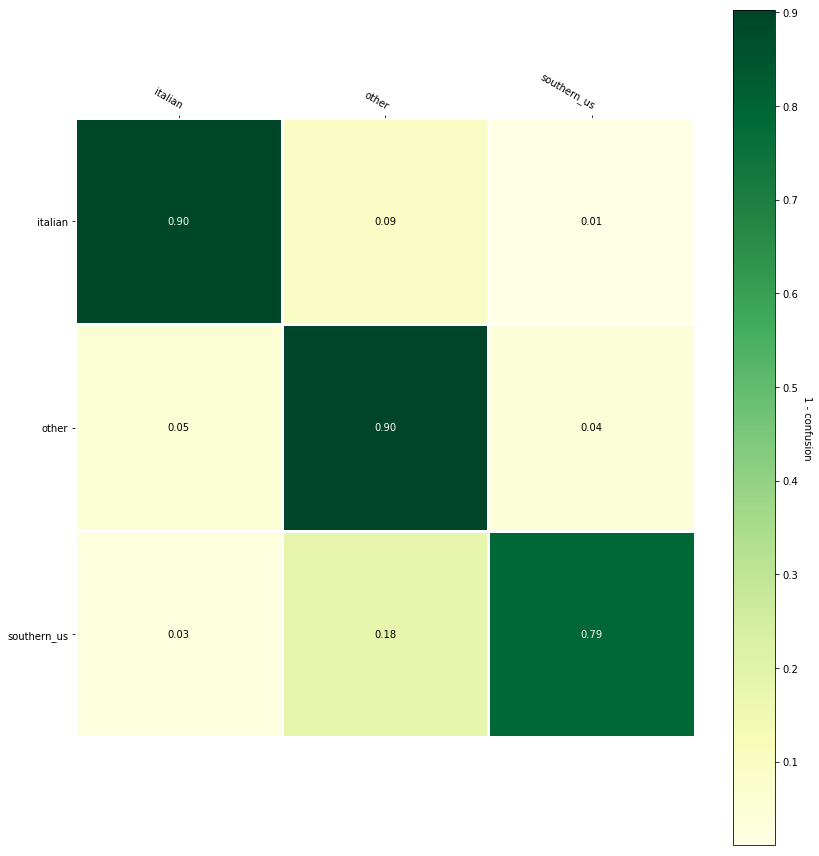

             precision    recall  f1-score   support

    italian       0.90      0.79      0.84      1603
      other       0.90      0.95      0.93      5527
southern_us       0.79      0.68      0.73       825

avg / total       0.89      0.89      0.89      7955



In [61]:
iso_svm = svm.LinearSVC(C = 0.1)
clf_confusion(iso_svm, x_train, y_simple_train, x_test, y_simple_test, ['italian', 'other', 'southern_us'], size = (12,12), normalize = 'rows')
iso_predictions = iso_svm.predict(x_test)
print(classification_report(y_simple_test, iso_predictions))

## Setup not italian, soutern_us data

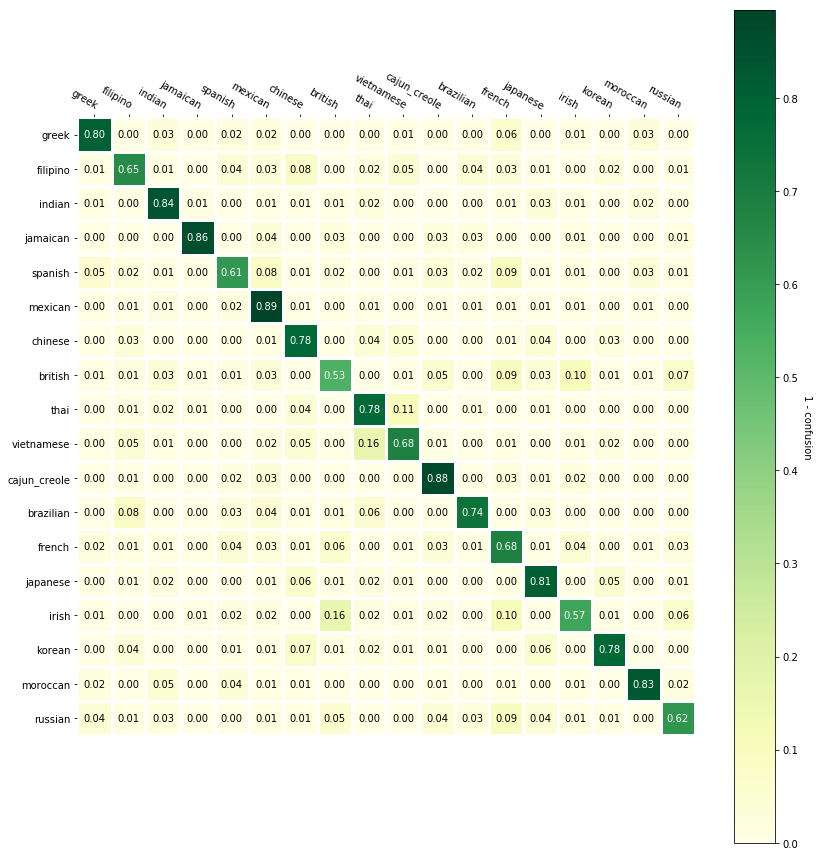

In [63]:
nis_svm = svm.LinearSVC(C = 0.1)
clf_confusion(nio_svm, x_nis_train, y_nis_train, x_nis_test, y_nis_test, nio_cuisines, size = (12,12), normalize = 'rows')

## Make twostep classifier

In [66]:
iso_svm = svm.LinearSVC(C = 0.1)
iso_svm.fit(x_train, y_train)

nis_svm = svm.LinearSVC(C = 0.1)
nis_svm.fit(x_nis_train, y_nis_train)

def two_step_predict(recipie) :
    row_recipie = recipie.reshape(1,-1)
    isoprediction = iso_svm.predict(row_recipie) 
    if isoprediction != 'other' :
        return isoprediction
    else :
        return nis_svm.predict(row_recipie)

print("Using two step prediction.")
two_step_predictions = np.apply_along_axis(two_step_predict, 1, x_test)
#print( accuracy_score())

Using two step prediction.


In [71]:
print("The two step svm has a accuracy of %.4f" %  accuracy_score(y_test, two_step_predictions.reshape(1,-1)[0])) 


The two step svm has a accuracy of 0.7788


In [73]:
onestep = svm.LinearSVC(C = 0.1)
onestep.fit(x_train, y_train)
osp = onestep.predict(x_test)
print("Using standard SVM we get an accurracy of %.4f" % accuracy_score(y_test, osp))

Using standard SVM we get an accurracy of 0.7788
